In [1]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("vlag"))

In [2]:
from datetime import datetime, timedelta

# BDay is business day, not birthday...
from pandas.tseries.offsets import BDay
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay

US_BUSINESS_DAY = CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [3]:
import yfinance as yf

# set the end date to today
end_date = datetime.today()
# set the start date to 5 years ago
start_date = end_date - timedelta(days=5 * 365)
print(start_date)

2019-09-07 11:16:59.750041


In [4]:
# list of tickers
tickers = [
    "QQQ",  # Invesco QQQ Trust Nasdaq 100
    "SHV",  # iShares Short Treasury Bond ETF
    "TLT",  # iShares 20+ Year Treasury Bond ETF
    # "DIS",  # Disney
    "PFE",  # Phizer
    "T",  # AT&T
    "GSK",  #
    "LVS",  # Las Vegas Sand Corp
    "OXY",  # Occidental Petroleum Corporation
    # 'MMM',  # 3M
    "KO",  # Coca-Cola
    "KHC",  # Kraft Heinz
    "ABT",  # Abbott Labs
]

# tickers = [
#     "QQQ",
#     "VHT",  # Vanguard Health Care Index Fund ETF Shares
#     "XLE",  # The Energy Select Sector SPDR Fund
#     "VCR",  # Vanguard Consumer Discretionary ETF
#     "VPU",  # Vanguard Utilities ETF

# ]
market = ["^GSPC"]

close_df = pd.DataFrame()
close_df = yf.download(tickers, start=start_date, end=end_date)["Close"]
market_df = yf.download(market, start=start_date, end=end_date)["Close"]

[*********************100%%**********************]  11 of 11 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
close_df.tail()

Ticker,ABT,GSK,KHC,KO,LVS,OXY,PFE,QQQ,SHV,T,TLT
Date,,,,,,,,,,,
2024-08-28,112.900002,43.900002,35.389999,71.750000,39.009998,56.779999,28.750000,471.350006,110.550003,19.82,97.849998
2024-08-29,112.760002,43.740002,35.259998,72.050003,38.639999,57.209999,28.719999,470.660004,110.559998,19.76,97.529999
2024-08-30,113.269997,43.910000,35.430000,72.470001,38.990002,56.980000,29.010000,476.269989,110.599998,19.90,96.489998
2024-09-03,114.660004,43.439999,35.590000,73.010002,38.680000,55.400002,28.299999,461.809998,110.160004,20.43,97.750000
2024-09-04,114.400002,44.259998,36.070000,72.559998,39.860001,54.630001,28.389999,460.609985,110.190002,20.57,99.010002


In [6]:
import matplotlib.pylab as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("Paired"))

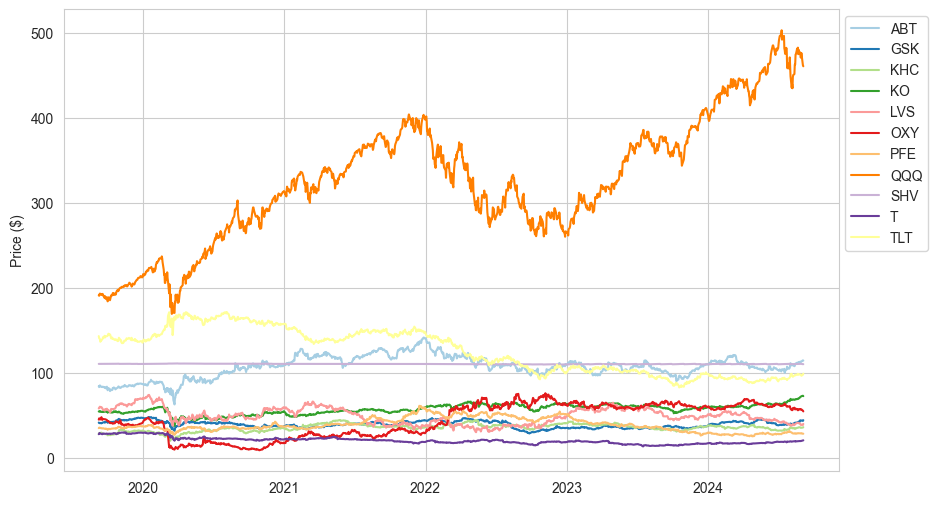

In [7]:
fig_prices, ax = plt.subplots(figsize=(10, 6))
for _c in close_df.columns:
    ax.plot(close_df[_c], label=_c)

ax.set_ylabel("Price ($)")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

# fig_prices

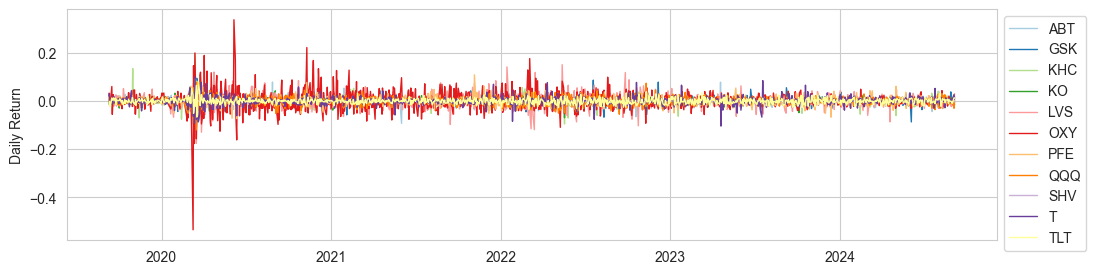

In [8]:
fig_daily_return, ax = plt.subplots(figsize=(12, 3))
for _c in close_df.columns:
    ax.plot(close_df[_c].pct_change(), label=_c, linewidth=1)
# ax.set_ylim([-0.6, 0.4])
ax.set_ylabel("Daily Return")
ax.legend(loc="best", bbox_to_anchor=(1, 1))

In [9]:
# annulized daily returns
close_df.pct_change().mean() * 252

Ticker
ABT    0.095649
GSK    0.041014
KHC    0.090101
KO     0.079110
LVS    0.024162
OXY    0.252293
PFE   -0.004753
QQQ    0.209112
SHV   -0.000544
T     -0.024803
TLT   -0.058010
dtype: float64

In [10]:
daily_returns = close_df.pct_change()

# annulized volatility
daily_returns.std() * np.sqrt(252)

Ticker
ABT    0.261489
GSK    0.236244
KHC    0.282898
KO     0.207748
LVS    0.446696
OXY    0.632214
PFE    0.272362
QQQ    0.254497
SHV    0.008790
T      0.266565
TLT    0.179465
dtype: float64

In [11]:
# individual Sharpe ratios
(close_df.pct_change().mean() * 252 - 0.03) / (daily_returns.std() * np.sqrt(252))

Ticker
ABT    0.251060
GSK    0.046621
KHC    0.212447
KO     0.236390
LVS   -0.013069
OXY    0.351611
PFE   -0.127597
QQQ    0.703789
SHV   -3.474949
T     -0.205591
TLT   -0.490404
dtype: float64

In [12]:
weights = np.array(len(tickers) * [1 / len(tickers)])
port_vol = np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov(), weights))) * np.sqrt(
    252
)
port_return = np.mean(close_df.pct_change().mean() * 252)

# portfolio volatility (equal weighted)
print("Portfolio volatility (equal weighted): {:.4%}".format(port_vol))

# portfolio return (equal weighted)
print("Portfolio return (equal weighted): {:.4%}".format(port_return))

print("Portfolio Sharpe ratio: {:4%}".format((port_return - 0.03) / port_vol))

Portfolio volatility (equal weighted): 16.3755%
Portfolio return (equal weighted): 6.3939%
Portfolio Sharpe ratio: 20.725620%


### Efficient Frontier

In [13]:
from scipy.optimize import minimize


class Portfolio:
    trading_days = 252

    def __init__(
        self,
        products_names: list,
        daily_prices: pd.DataFrame,
        risk_free: float,
        weights=None,
    ) -> None:
        self.products = products_names
        self.daily_prices = daily_prices
        self.risk_free = risk_free
        # equally weighted by default
        if weights is None:
            self.weights = np.array(len(self.products) * [1 / len(self.products)])
        else:
            self.weights = weights

    def daily_returns(self):
        return self.daily_prices.pct_change().dropna(how="any")

    def port_ret(self):
        mean = self.daily_returns().mean()
        return np.sum(mean * self.weights) * self.trading_days

    def port_vol(self):
        cov = self.daily_returns().cov()
        return np.sqrt(np.dot(self.weights.T, np.dot(cov, self.weights))) * np.sqrt(
            self.trading_days
        )

    def sharpe_ratio(self):
        return (self.port_ret() - self.risk_free) / self.port_vol()

    def manual_input_weights(self):
        print("Fill in the current value of each asset (in $): ")
        values = []
        for p in self.products:
            v = input(p + ": ")
            if len(v) == 0:
                values.append(0)
            else:
                values.append(float(v))
        self.weights = np.array(values) / sum(values)
        self.info(sum(values))

    def info(self, total_value=None):
        print("Portfolio composition: ")
        if total_value is None:
            print("{:^11s} {:>8s}  ".format("Products", "Weights",))
            for i in range(len(self.products)):
                print(
                    "{:^11s} {:>8.2%} ".format(
                        self.products[i], self.weights.tolist()[i],
                    )
                )
        else:
            values = self.weights * total_value
            print("{:^11s} {:>8s}  {:>10s}".format("Products", "Weights", "Amounts"))
            for i in range(len(self.products)):
                print(
                    "{:^11s} {:>8.2%}  ${:>9,.2f}".format(
                        self.products[i], self.weights.tolist()[i], values[i]
                    )
                )
        print("{:>20s}: {:>8.2%}".format("Expected return", self.port_ret()))
        print("{:>20s}: {:>8.2%}".format("Standard Deviation", self.port_vol()))
        print("{:>20s}: {:>8.2%}".format("Sharpe Ratio", self.sharpe_ratio()))

In [14]:
port = Portfolio(tickers, close_df, 0.03)
# portfolio volatility (equal weighted)
print("Portfolio volatility (equal weighted): {:.4%}".format(port.port_vol()))
# portfolio return (equal weighted)
print("Portfolio return (equal weighted): {:.4%}".format(port.port_ret()))
print("Portfolio Sharpe ratio: {:4%}".format(port.sharpe_ratio()))

Portfolio volatility (equal weighted): 16.3755%
Portfolio return (equal weighted): 6.3939%
Portfolio Sharpe ratio: 20.725620%


In [15]:
from pandas import DataFrame
from tqdm import tqdm


class EfficientFrontier(Portfolio):
    def __init__(
        self,
        products_names: list,
        daily_prices: DataFrame,
        risk_free: float,
        weights=None,
        seed: np.int32 = 123,
        n: np.int32 = 10,
    ) -> None:
        super().__init__(products_names, daily_prices, risk_free, weights)
        self.seed = seed
        self.set_seed()
        self.n = n

    def set_seed(self):
        np.random.seed(self.seed)
        print("Set seed as", self.seed)

    def get_random_weights(self):
        r_weights = np.random.uniform(low=0, high=1, size=len(self.products))
        r_weights = r_weights / np.sum(r_weights)
        return r_weights

    def get_risk_return_spectrum(self):
        rr_list = []
        for _i in tqdm(range(self.n)):
            self.weights = self.get_random_weights()
            rr_list.append([self.port_ret(), self.port_vol(), self.sharpe_ratio()])

        return pd.DataFrame(data=rr_list, columns=["return", "std", "sharpe_ratio"])

In [16]:
ef = EfficientFrontier(tickers, close_df, 0.03, n=10**3)
# ef.get_random_weights().shape
rr_df = ef.get_risk_return_spectrum()

Set seed as 123


100%|██████████| 1000/1000 [00:06<00:00, 154.82it/s]


In [17]:
rr_df.shape

(1000, 3)

In [18]:
rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]["return"]

0.11413398051969147

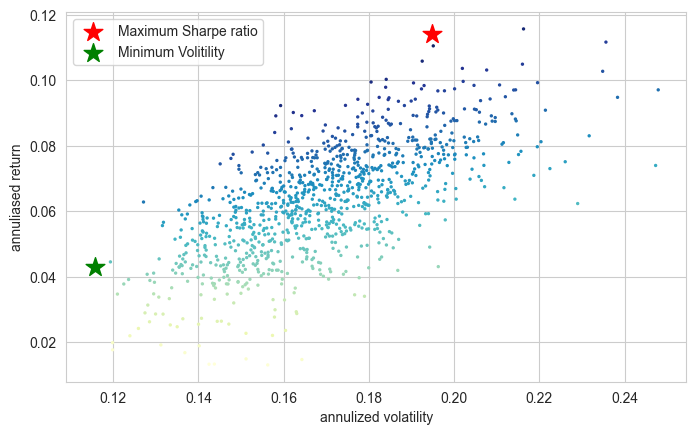

In [19]:
max_sr = rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]
min_sd = rr_df.iloc[rr_df["std"].idxmin()]

fig_efficient_frontier, ax = plt.subplots(figsize=(8, 4.8))
ax.scatter(rr_df["std"], rr_df["return"], c=rr_df["sharpe_ratio"], cmap="YlGnBu", s=2)
ax.scatter(
    max_sr["std"],
    max_sr["return"],
    marker="*",
    color="r",
    s=200,
    label="Maximum Sharpe ratio",
)
ax.scatter(
    min_sd["std"],
    min_sd["return"],
    marker="*",
    color="g",
    s=200,
    label="Minimum Volitility",
)
ax.set_ylabel("annuliased return")
ax.set_xlabel("annulized volatility")
ax.legend()

The efficient frontier is not particularly apparent. 

According to this [page](https://quant.stackexchange.com/questions/44210/efficient-frontier-doesnt-look-good), the frontier can also be constructed with the combinations of just two efficient portfolios (e.g. the max sharpe and the min. variance portfolios).

$$
weights = w * \pi_{max\_sr} + (1 - w) * \pi_{min\_var}
$$

### Modern Portfolio Theory (MPT)

In [20]:
from pandas import DataFrame
from scipy.optimize import minimize


class EfficientPortfolio(Portfolio):
    def __init__(
        self,
        products_names: list,
        daily_prices: DataFrame,
        risk_free: float,
        weights=None,
    ) -> None:
        super().__init__(products_names, daily_prices, risk_free, weights)
        self.efficiency: str = "Not optimized"

    def _minus_SR(self, weights):
        self.weights = weights
        return -self.sharpe_ratio()

    def _port_vol_opt(self, weights):
        self.weights = weights
        return self.port_vol()

    def maximiaze_SR(self):
        # constraints, sum of weights = 1
        cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        # bounds on weights: [0, 1]
        bnds = tuple((0, 1) for x in range(len(self.products)))
        # initial guess
        init_w = self.weights
        opts = minimize(
            self._minus_SR, init_w, method="SLSQP", bounds=bnds, constraints=cons
        )
        self.weights = opts.x
        self.efficiency = "Maximized Sharpe Ratio"

    def minimize_sd(self):
        # constraints, sum of weights = 1
        cons = {"type": "eq", "fun": lambda x: np.sum(x) - 1}
        # bounds on weights: [0, 1]
        bnds = tuple((0, 1) for x in range(len(self.products)))
        # initial guess
        init_w = self.weights
        opts = minimize(
            self._port_vol_opt, init_w, method="SLSQP", bounds=bnds, constraints=cons
        )
        self.weights = opts.x
        self.efficiency = "Minimized volatility"

In [21]:
eff_port = EfficientPortfolio(
    port.products,
    port.daily_prices,
    port.risk_free,
)
print(eff_port.efficiency)
eff_port.info()

Not optimized
Portfolio composition: 
 Products    Weights  
    QQQ        9.09% 
    SHV        9.09% 
    TLT        9.09% 
    PFE        9.09% 
     T         9.09% 
    GSK        9.09% 
    LVS        9.09% 
    OXY        9.09% 
    KO         9.09% 
    KHC        9.09% 
    ABT        9.09% 
     Expected return:    6.39%
  Standard Deviation:   16.38%
        Sharpe Ratio:   20.73%


In [22]:
eff_port.maximiaze_SR()
print(eff_port.efficiency)
eff_port.info()

Maximized Sharpe Ratio
Portfolio composition: 
 Products    Weights  
    QQQ        0.00% 
    SHV        0.00% 
    TLT        0.00% 
    PFE        0.00% 
     T         0.00% 
    GSK        8.48% 
    LVS        0.00% 
    OXY       91.52% 
    KO         0.00% 
    KHC        0.00% 
    ABT        0.00% 
     Expected return:   21.28%
  Standard Deviation:   25.44%
        Sharpe Ratio:   71.83%


In [23]:
eff_port.minimize_sd()
print(eff_port.efficiency)
eff_port.info()

Minimized volatility
Portfolio composition: 
 Products    Weights  
    QQQ        0.05% 
    SHV        0.00% 
    TLT        0.00% 
    PFE        0.03% 
     T         0.05% 
    GSK        0.03% 
    LVS        0.16% 
    OXY        0.00% 
    KO        99.67% 
    KHC        0.01% 
    ABT        0.00% 
     Expected return:   -0.04%
  Standard Deviation:    0.88%
        Sharpe Ratio: -347.00%


In [24]:
eff_port_max_sr = EfficientPortfolio(port.products, port.daily_prices, port.risk_free)
eff_port_max_sr.maximiaze_SR()
eff_port_min_sd = EfficientPortfolio(port.products, port.daily_prices, port.risk_free)
eff_port_min_sd.minimize_sd()

In [25]:
_rr_list = []
for _w in np.linspace(-0.2, 1.3, num=10**3):
    _combined_weights = (
        _w * eff_port_max_sr.weights + (1 - _w) * eff_port_min_sd.weights
    )
    _port = Portfolio(tickers, close_df, 0.03, weights=_combined_weights)
    _rr_list.append(
        [
            _port.port_ret(),
            _port.port_vol(),
            _port.sharpe_ratio(),
        ]
    )
rr_df = pd.DataFrame(data=_rr_list, columns=["return", "std", "sharpe_ratio"])

In [26]:
from itertools import compress

_rr_indi_l = []
for _w in np.identity(n=len(tickers)):
    _port = Portfolio(tickers, close_df, 0.03, weights=_w)
    _rr_indi_l.append(
        [
            _port.port_ret(),
            _port.port_vol(),
            _port.sharpe_ratio(),
            list(compress(tickers, _w))[0],
        ]
    )
rr_indi_df = pd.DataFrame(
    data=_rr_indi_l, columns=["return", "std", "sharpe_ratio", "ticker"]
)

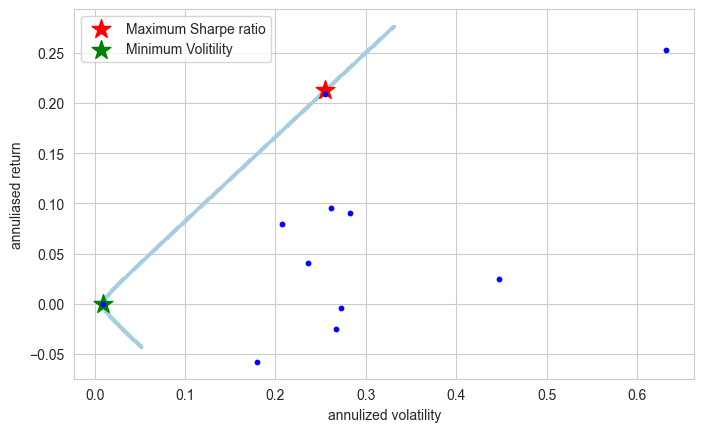

In [27]:
# max_sr = rr_df.iloc[rr_df["sharpe_ratio"].idxmax()]
min_sd = rr_df.iloc[rr_df["std"].idxmin()]

fig_efficient_frontier, ax = plt.subplots(figsize=(8, 4.8))
ax.scatter(rr_df["std"], rr_df["return"], s=2)
ax.scatter(
    eff_port_max_sr.port_vol(),
    eff_port_max_sr.port_ret(),
    marker="*",
    color="r",
    s=200,
    label="Maximum Sharpe ratio",
)
ax.scatter(
    min_sd["std"],
    min_sd["return"],
    marker="*",
    color="g",
    s=200,
    label="Minimum Volitility",
)
ax.scatter(
    rr_indi_df["std"],
    rr_indi_df["return"],
    s=10,
    c="b",
)
ax.set_ylabel("annuliased return")
ax.set_xlabel("annulized volatility")
ax.legend()

In [28]:
port.manual_input_weights()

Fill in the current value of each asset (in $): 
Portfolio composition: 
 Products    Weights     Amounts
    QQQ       32.65%  $ 1,287.43
    SHV       13.90%  $   548.23
    TLT        9.28%  $   366.00
    PFE        3.60%  $   142.00
     T         3.65%  $   144.13
    GSK        7.82%  $   308.42
    LVS        5.01%  $   197.38
    OXY        6.96%  $   274.50
    KO         3.68%  $   145.06
    KHC        1.83%  $    72.20
    ABT       11.62%  $   458.30
     Expected return:    7.59%
  Standard Deviation:   16.79%
        Sharpe Ratio:   27.30%


In [29]:
port.info()

Portfolio composition: 
 Products    Weights  
    QQQ       32.65% 
    SHV       13.90% 
    TLT        9.28% 
    PFE        3.60% 
     T         3.65% 
    GSK        7.82% 
    LVS        5.01% 
    OXY        6.96% 
    KO         3.68% 
    KHC        1.83% 
    ABT       11.62% 
     Expected return:    7.59%
  Standard Deviation:   16.79%
        Sharpe Ratio:   27.30%
